In [13]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import numpy as np
import matplotlib.pyplot as plt

# Aristas

In [14]:
class Edge: 
    
    def __init__(self, x0, y0, x1, y1, segments = 1):
        self.P0 = np.array([x0,y0])
        self.P1 = np.array([x1,y1])
        self.N = segments
        self.points = np.array([(i/self.N) * (self.P1-self.P0) + self.P0 for i in range(0, self.N+1)])
        
    def get_P0(self):
        return self.P0
    
    def get_P1(self):
        return self.P1 
    
    def get_points(self):
        return self.points

    def get_len(self):
        return np.linalg.norm(self.P0 - self.P1)
    
    def get_kp(self):
        return self.get_len()/self.N
    
    def apply_force(self, F, ds):
        self.points[1:-1] += F * ds
    
    def get_midpoint(self):
        return (self.P1 + self.P0)/2
       

In [15]:
def spring_force(p, p_other, kp):
    return kp * (p_other - p)

def electro_force(p, p_other, C):
    lp = np.linalg.norm(p_other - p)
    return C* (p_other - p)/lp**2

def calcular_fuerzas(ps, qs, i, kp, C):
    """
    - ps: todos los nodos de la arista que recibe la fuerza, incluyendo extremos
    - qs: todos los nodos de la arista que aplica la fuerza, incluyendo extremos
    - i: un index interior de p (ni el primero ni el ultimo), el del nodo que recibe la fuerza
    - kp: constante de resorte de la arista P
    - kq: constante de resorte de la arista Q
    - C: compatibilidad
    """
    Fp = spring_force(ps[i], ps[i-1], kp) + spring_force(ps[i], ps[i+1], kp) + electro_force(ps[i], qs[i], C)
    return Fp

def bundling_iteration(P, Q, ds = 0.1, C = 1.0):
    ps = P.get_points()
    qs = Q.get_points()
    kp = P.get_kp()
    kq = Q.get_kp()

    inner_range = range(1, len(ps)-1)
    
    Fp = np.array([calcular_fuerzas(ps, qs, i, kp, C) for i in inner_range])
    Fq = np.array([calcular_fuerzas(qs, ps, i, kq, C) for i in inner_range])
    P.apply_force(Fp, ds)
    Q.apply_force(Fq, ds)
    

def plot_points(ps, label = ""):
    plt.plot(ps[:,0],ps[:,1], '-o', label = label)

def plot_edges(Ps, labels):
    for P, lab in zip(Ps, labels):
        plot_points(P.get_points(), label = lab)

In [16]:
@interact
def bundle_and_plot(ds=0.0, N = (3, 8, 1)):
    P = Edge(0.5, 1., 5., 3., N)
    Q = Edge(1., 4., 6., 2., N)
    bundling_iteration(P, Q, ds)    
    plt.figure()
    plt.title("Aristas Deformadas")
    plot_edges([P, Q], ["P", "Q"])   


interactive(children=(FloatSlider(value=0.0, description='ds', max=1.0), IntSlider(value=5, description='N', m…

# Medidas de compatibilidad de aristas

Para dos aristas $P$ y $Q$, definiremos una serie de medidas que toman valores en $[0,1]$. Mientras mayor el valor de la medida, diremos que mayor es la compatibilidad de esas aristas.

## Compatibilidad de ángulos

Mientras más perpendiculares son dos aristas, menos deberían deformarse la una a la otra. Definimos
$$
C_\alpha(P,Q) = |\cos(\alpha)|
$$
donde $\alpha = \frac{\arccos(P \cdot Q)}{|P| \, |Q|}$ (aquí hay un abuso de notación, $P \cdot Q$ se refiere al producto punto $\langle P_0 - P_1, Q_0 - Q_1 \rangle$), es decir, el ángulo entre las dos aristas. Notamos que si $P$ y $Q$ son paralelas, entonces $\alpha = 0$ y $C_\alpha(P,Q) = 1$; la compatibilidad es máxima. Si $P$ y $Q$ son perpendiculares, entonces $\alpha = \frac{\pi}{2}$ y $C_\alpha(P,Q) = 0$ (compatibilidad mínima).

In [28]:
def C_a(P,Q):
    vecP = P.get_P1() - P.get_P0()
    vecQ = Q.get_P1() - Q.get_P0()
    Ca = np.dot(vecP, vecQ)/ (P.get_len() * Q.get_len())
    return max(0., Ca)

In [31]:
@interact
def changing_angle_and_plot(angle_mult = (-1.0, 1.0, 0.1), ds = (0.0, 0.5, 0.05)):
    a = angle_mult * np.pi
    N = 5
    L = 3.
    P = Edge(-L, 0., L, 0., N)
    Phat = Edge(-L, 0., L, 0., N)
    Q = Edge(-L*np.cos(a), -L * np.sin(a), L*np.cos(a), L*np.sin(a), N)
    Qhat = Edge(-L*np.cos(a), -L * np.sin(a), L*np.cos(a), L*np.sin(a), N)
    bundling_iteration(P, Q, ds)
    ca = C_a(Phat, Qhat)
    bundling_iteration(Phat, Qhat, ds, ca)    
    plt.figure(figsize = (10,5))
    plt.subplot(121)
    plt.title(f"Sin C_a, alpha = {angle_mult} pi")
    plt.xlim = (-3,3)
    plt.axis('equal')
    plot_edges([P, Q], ["P", "Q"])  
    plt.subplot(122)
    plt.title(f"Con C_a = {ca:.2}")
    plt.xlim = (-3,3)
    plt.axis('equal')
    plot_edges([Phat, Qhat], ["P", "Q"])  

interactive(children=(FloatSlider(value=0.0, description='angle_mult', max=1.0, min=-1.0), FloatSlider(value=0…

*Encontré un efecto indeseado, las aristas enumeradas en sentido opuesto se deforman excesivamente*

## Compatibilidad de escala

Mientras más distintos son los largos de dos aristas, menos deberían deformarse la una a la otra. Definimos 
$$
C_S(P,Q) = \frac{2}{l_{avg} \min(|P|, |Q|) + \max(|P|, |Q|)/l_{avg}}
$$
donde $l_{avg} = \frac{|P| + |Q|}{2}$.

Notamos que la función que define el paper tiene un error. La idea de esta medida es que si el ratio $|P|/|Q| \approx 1$, entonces la compatibilidad sea máxima ($C_S(P,Q) \approx 1$), y si una arista es mucho más grande que la otra, ie. ratio $|P|/|Q| \to \infty$, entonces la compatibilidad sea mínima ($C_S(P,Q) \approx 0$). Eso no se logra en esa función, pero puede corregirse cambiando en el denominador $l_{avg} \min(|P|, |Q|) $ a $\frac{l_{avg}}{\min(|P|, |Q|)}$. La nueva función 
$$
C_S(P,Q) = \frac{2}{\frac{l_{avg}}{\min(|P|, |Q|)} + \max(|P|, |Q|)/l_{avg}}
$$
da muchos mejores resultados, como puede verse en el gráfico de más abajo:

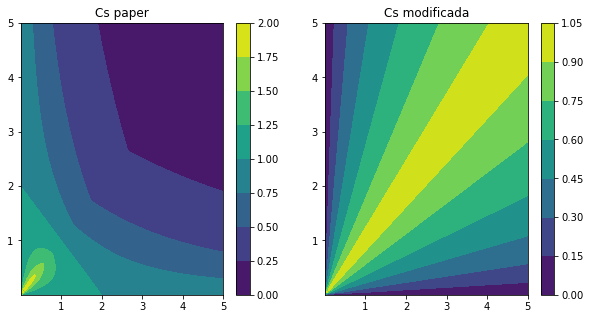

In [18]:
Cs_paper = lambda x,y: 2/((x+y)/2 * np.minimum(x,y) + np.maximum(x,y)*2/(x+y))
Cs_modif = lambda x,y: 2/((x+y)/2 /np.minimum(x,y) + np.maximum(x,y)*2/(x+y))

xs = np.linspace(0.001,5.001, 100)
ys = np.linspace(0.001,5.001, 100)
X, Y = np.meshgrid(xs, ys)
plt.figure(figsize = (10,5))
plt.subplot(121)
plt.title("Cs paper")
plt.contourf(X, Y, Cs_paper(X,Y))
plt.colorbar()
plt.subplot(122)
plt.title("Cs modificada")
plt.contourf(X, Y, Cs_modif(X,Y))
plt.colorbar()
plt.show()

In [19]:
def C_S(P,Q):
    lenP = P.get_len()
    lenQ = Q.get_len()
    lavg = (lenP + lenQ)/2
    return 2/(lavg / min(lenP, lenQ) + max(lenP, lenQ)/lavg)

In [20]:
@interact
def changing_len_and_plot(L = (2., 15.0, 1.), ds = (0.0, 0.8, 0.05)):
    N = 8
    P = Edge(-L/2, 1.5, L/2, 1.5, N)
    Phat = Edge(-L/2, 1.5, L/2, 1.5, N)
    Q = Edge(-1., 0., 1., 0., N)
    Qhat = Edge(-1., 0., 1., 0., N)
    bundling_iteration(P, Q, ds)
    cs = C_S(Phat, Qhat)
    bundling_iteration(Phat, Qhat, ds, cs)    
    plt.figure(figsize = (10,7))
    ax1 = plt.subplot(211)
    ax1.set_title(f"Sin C_s, Largo = {L}")
    ax1.set_xlim((-5.2,5.2))
    ax1.set_ylim((0,2))
    plot_edges([P, Q], ["P", "Q"])  
    ax2 = plt.subplot(212)
    ax2.set_title(f"Con C_s = {cs:.2}")
    ax2.set_xlim((-5.2,5.2))
    ax2.set_ylim((0,2))
    plot_edges([Phat, Qhat], ["P", "Q"])  

interactive(children=(FloatSlider(value=8.0, description='L', max=15.0, min=2.0, step=1.0), FloatSlider(value=…

## Compatibilidad de posición

Aristas muy lejanas no deberían doblarse entre ellas. Se define
$$
C_P(P,Q) = \frac{l_{avg}}{l_{avg} + \|P_m - Q_m\|}
$$
donde $P_m, Q_m$ son los puntos medios de $P$ y $Q$ respectivamente.

Notamos que mientras más cercano están los puntos medios de dos aristas, más cercano a 1 es $C_P$. En particular, si $P_m = Q_m$, entonces $C_P = 1$. Cuando los puntos medios son lejanos, la compatibilidad se acerca a 0.

In [24]:
def C_P(P,Q):
    lavg = (P.get_len() + Q.get_len())/2
    Pm = P.get_midpoint()
    Qm = Q.get_midpoint()    
    return lavg/(lavg + np.linalg.norm(Pm - Qm))

In [28]:
@interact
def changing_len_and_plot(altura = (0.0, 5.0, 0.5), ds = (0.0, 0.8, 0.05)):
    N = 8
    P = Edge(-2, altura, 2, altura, N)
    Phat = Edge(-2, altura, 2, altura, N)
    Q = Edge(-2., 0., 2., 0., N)
    Qhat = Edge(-2., 0., 2., 0., N)
    bundling_iteration(P, Q, ds)
    cp = C_P(Phat, Qhat)
    bundling_iteration(Phat, Qhat, ds, cp)    
    plt.figure(figsize = (10,7))
    ax1 = plt.subplot(211)
    ax1.set_title(f"Sin C_p, |Pm - Qm| = {altura}")
    ax1.set_xlim((-2.5,2.5))
    ax1.set_ylim((-0.5,5.5))
    plot_edges([P, Q], ["P", "Q"])  
    ax2 = plt.subplot(212)
    ax2.set_title(f"Con C_p = {cp:.2}")
    ax2.set_xlim((-2.5,2.5))
    ax2.set_ylim((-0.5,5.5))
    plot_edges([Phat, Qhat], ["P", "Q"])  

interactive(children=(FloatSlider(value=2.5, description='altura', max=5.0, step=0.5), FloatSlider(value=0.4, …

## Compatibilidad de visibilidad

Aristas fuera del "campo de visión" deberían influir tener menos influencia. Se define 
$$
C_V(P,Q) = \min(V(P,Q), V(Q,P))
$$
donde $V(P,Q) = \max(1 - 2\frac{\|P_m - I_m\|}{\|I_0 - I_1\|}, 0)$. $I$ corresponde a la sección de la arista $P$ extendida que es *visible* desde $Q$ (ver imagen)
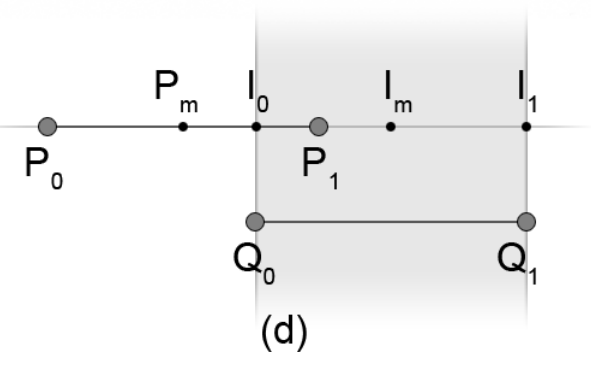


In [108]:
#np.dot(vecP, vecQ)/ 
P.get_len()

In [100]:
P.get_len()

18.5

AxisError: axis 2 is out of bounds for array of dimension 0

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [94]:
x = np.array([1,2])
y = np.array([4,0])
np.max(x,y)

TypeError: only integer scalar arrays can be converted to a scalar index